<img src='https://gazetadasemana.com.br/images/noticias/78040/30064552_altaLOGOS_.png.png' width=500>

# Oversampling
Authorship: Raul Macedo


It has been observed, through training a model with MLPClassifier, that there is a deficiency of class 0 in the PRP data (resulting in oversampling for failure class 5 data). This scenario is likely due to the transformation of transition data into failure data.

To overcome the absence of zero classes, two workarounds have been proposed and will be employed:

1. Artificially create more class 0 data using the SMOTE method.
2. Include additional normal operation data in the dataset, already present in the 3W.

## **1. Artificial Filling**
The SMOTE method is going to be used to fill data artificially

In [26]:
#General imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pandas import DataFrame
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.model_selection import train_test_split
from utils import save_csv_if_doesnt_exist



In [3]:
PRP_df = pd.read_csv('./PRP_treated_data.csv')

# Evaluating the predominance of the "class"

In [4]:
count_classes = pd.value_counts(PRP_df['class'], sort = True).sort_index()
count_classes

0.0     33535
5.0    328463
Name: class, dtype: int64

In [5]:
X = PRP_df.drop(columns=['Unnamed: 0', 'timestamp','class','file_name'],axis=1).copy()
Y = PRP_df['class']

In [6]:
counter = Counter(Y)
for k,v in counter.items():
	per = v / len(Y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

Class=0, n=33535 (9.264%)
Class=5, n=328463 (90.736%)


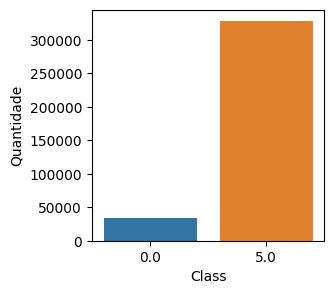

In [7]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(3,3))
ax = sns.countplot(data=PRP_df, x=Y)
np.bincount(Y)
plt.xlabel("Class")
plt.ylabel("Quantidade")
plt.show()

In order to mitigate the imbalance in the distribution of artificial data among the test data, it is advisable to perform the relative data filling within the already subdivided sets found in this work in the directory `feature_selection_results`. Thus, the 3 training training csvs must be filled artificially.

In [8]:
train1 = pd.read_csv('./feature_selection_results/train1.csv')
train2 = pd.read_csv('./feature_selection_results/train2.csv')
train3 = pd.read_csv('./feature_selection_results/train3.csv')


In order to try to observe a more expressive behavior in the trainings, we will increase the quantity of class 0 vectors in each dataset by 3X.

In [9]:
def fill_artificial_data(dataset:DataFrame,multiplier = 3):
    """Uses SMOTE to increase data for 0 class in de given dataset by the given multiplier
    This function is not as much generic as it could be, it works only for the context of this notebook. 
    Parameters
    ----------
    dataset: Pandas.DataFrame
    Dataset to increase the quantity of vectors with 0 class
    multiplier: int or float
    factor to increase the size of data"""
    X = dataset.drop(columns=['0'],axis=1).copy()
    Y = dataset['0']
    zero_quantity = len(dataset[dataset['0']==0.0])
    five_quantity = len(dataset[dataset['0']==5.0])
    sm = SMOTE(sampling_strategy={0.0:zero_quantity*multiplier,5.0:five_quantity},k_neighbors=5)
    X,Y = sm.fit_resample(X,Y)
    counter = Counter(Y)
    for k,v in counter.items():
        per = v / len(Y) * 100
        print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
    print('\n')
    return pd.concat([X,Y], axis=1)

In [10]:
train1_fill = fill_artificial_data(train1)
train2_fill = fill_artificial_data(train2)
train3_fill = fill_artificial_data(train3)

Class=5, n=229923 (76.552%)
Class=0, n=70425 (23.448%)


Class=5, n=229900 (76.533%)
Class=0, n=70494 (23.467%)


Class=5, n=229849 (76.490%)
Class=0, n=70647 (23.510%)




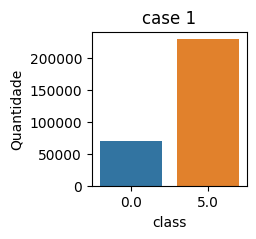

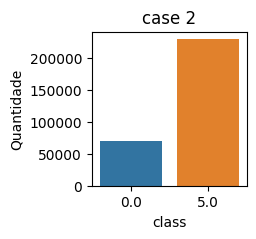

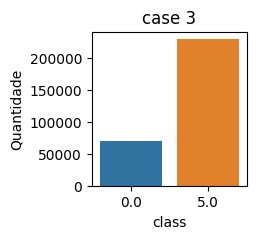

In [11]:
fig = plt.figure(figsize=(2,2))
ax = sns.countplot(data=train1_fill, x=train1_fill['0'])
np.bincount(train1_fill['0'])
plt.xlabel("class")
plt.ylabel("Quantidade")
plt.title('case 1')
plt.show()
##
fig = plt.figure(figsize=(2,2))
ax = sns.countplot(data=train2_fill, x=train2_fill['0'])
np.bincount(train2_fill['0'])
plt.xlabel("class")
plt.ylabel("Quantidade")
plt.title('case 2')
plt.show()
##
fig = plt.figure(figsize=(2,2))
ax = sns.countplot(data=train3_fill, x=train3_fill['0'])
np.bincount(train3_fill['0'])
plt.xlabel("class")
plt.ylabel("Quantidade")
plt.title('case 3')
plt.show()

In [14]:

save_csv_if_doesnt_exist(train1_fill,'./oversampling/oversampling_with_artificial_data/train_data_fill1.csv')
save_csv_if_doesnt_exist(train2_fill,'./oversampling/oversampling_with_artificial_data/train_data_fill2.csv')
save_csv_if_doesnt_exist(train3_fill,'./oversampling/oversampling_with_artificial_data/train_data_fill3.csv')

## **2. Filling with real data**
Data from the 3W will be used.
In this case, considering that the data is reliable, the attempt will be to increase the concentration of class 0 to at least close to the failure data.
For this purpose, the same treatments applied to the PRP data will be applied to the real data, which include filling NaN values in the class 0 (since they correspond to normal operation) and removing the column not considered in the PRP analysis: T-JUS-CKGL.

All normal operation real data files have an average of 17,800 vectors. Taking this into account, approximately 16 files will be required to make the data equivalent in quantity.

In [19]:
master5_df = pd.read_csv('./main_class_five_&_zero.csv')

Obtaining the names of the first 16 files with class 0 and removing the columns.

In [16]:
files = np.unique(master5_df['file_name'])

In [17]:
files = list(files[:16])

normal_operation_dfs = master5_df[(master5_df['class']==0.0) & (master5_df['file_name'].isin(files))]
normal_operation_dfs=normal_operation_dfs.drop(columns=['T-JUS-CKGL','QGL','event'])

In [21]:
data_balance_with_real = pd.concat([PRP_df,normal_operation_dfs])

In [22]:
X2 = data_balance_with_real.drop(columns=['Unnamed: 0', 'timestamp','class','file_name']).copy()
Y2 = data_balance_with_real['class']

In [23]:
counter = Counter(Y2)
for k,v in counter.items():
	per = v / len(Y2) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

Class=0, n=319730 (49.326%)
Class=5, n=328463 (50.674%)


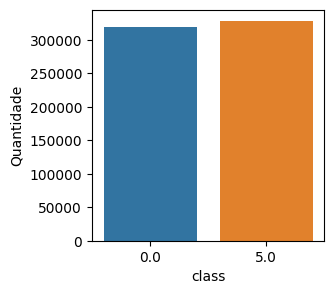

In [24]:
fig = plt.figure(figsize=(3,3))
ax = sns.countplot(data=data_balance_with_real, x=Y2)
np.bincount(Y2)
plt.xlabel("class")
plt.ylabel("Quantidade")
plt.show()

## Splitting Real oversampled data into training and testing data

In [28]:

in_1_real = data_balance_with_real.drop(columns=['Unnamed: 0','file_name','timestamp','class'],axis=1).copy()
in_2_real = data_balance_with_real.drop(columns=['Unnamed: 0','file_name','timestamp','T-TPT', 'P-MON-CKP','class'],axis=1).copy()
in_3_real = data_balance_with_real.drop(columns=['Unnamed: 0','file_name','timestamp','P-TPT', 'P-MON-CKP','class'],axis=1).copy()
out_real = pd.DataFrame(data_balance_with_real['class'])

In [29]:
train_in1_real,test_in1_real,train_out1_real,test_out1_real = train_test_split(in_1_real,out_real,test_size=0.3)
train_in2_real,test_in2_real,train_out2_real,test_out2_real = train_test_split(in_2_real,out_real,test_size=0.3)
train_in3_real,test_in3_real,train_out3_real,test_out3_real = train_test_split(in_3_real,out_real,test_size=0.3)

In [30]:
train_fill_real1 = pd.concat([train_in1_real,train_out1_real],axis=1)
test_fill_real1 = pd.concat([test_in1_real,test_out1_real],axis=1)
train_fill_real2 = pd.concat([train_in2_real,train_out2_real],axis=1)
test_fill_real2 = pd.concat([test_in2_real,test_out2_real],axis=1)
train_fill_real3 = pd.concat([train_in3_real,train_out3_real],axis=1)
test_fill_real3 = pd.concat([test_in3_real,test_out3_real],axis=1)

In [32]:
save_csv_if_doesnt_exist(train_fill_real1,'./oversampling/oversampling_with_real_data/train_real_filled_data1.csv')
save_csv_if_doesnt_exist(test_fill_real1,'./oversampling/oversampling_with_real_data/test_real_filled_data1.csv')
save_csv_if_doesnt_exist(train_fill_real2,'./oversampling/oversampling_with_real_data/train_real_filled_data2.csv')
save_csv_if_doesnt_exist(test_fill_real2,'./oversampling/oversampling_with_real_data/test_real_filled_data2.csv')
save_csv_if_doesnt_exist(train_fill_real3,'./oversampling/oversampling_with_real_data/train_real_filled_data3.csv')
save_csv_if_doesnt_exist(test_fill_real3,'./oversampling/oversampling_with_real_data/test_real_filled_data3.csv')